In [178]:
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, RobustScaler
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [179]:
df_raw = pd.read_csv("../Data/df_train_preprocessed.csv")
df_raw.head()

,is_listened,sample_id,genre_id,ts_listen,media_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,listen_month,listen_week,listen_weekday,listen_hour,release_month
0,0,0,25471,1480597215,222606,12,20040704,1,0,223,0,0,9241,55164,29,12,48,3,14,8
1,1,1,25571,1480544735,250467,0,20060301,2,1,171,0,0,16547,55830,30,11,48,2,23,8
2,1,2,16,1479563953,305197,1,20140714,2,1,149,1,1,7665,2704,29,11,46,5,14,8
3,0,3,7,1480152098,900502,0,20001030,0,0,240,0,1,1580,938,30,11,47,5,10,8
4,1,4,7,1478368974,542335,0,20080215,0,0,150,0,1,1812,2939,24,11,44,5,19,8


#### Create subsample

In [180]:
df_raw = df_raw[df_raw["user_id"] < 200]
df_raw = df_raw[df_raw["media_id"] < 400000]
df_raw.shape

(3007, 20)

## Create table on groupby

In [181]:
df = df_raw.groupby(["user_id", "media_id", "genre_id", "artist_id", "listen_hour"], 
                               as_index=False)["is_listened"].sum()
df

,user_id,media_id,genre_id,artist_id,listen_hour,is_listened
0,0,211678,2,6635,10,1
1,0,211678,2,6635,14,2
2,0,211678,2,6635,16,1
3,0,211678,2,6635,19,1
4,0,211678,2,6635,20,1
...,...,...,...,...,...,...
2567,198,365155,7,13922,18,0
2568,198,365155,7,13922,21,0
2569,198,365155,7,13922,22,1
2570,199,211678,2,6635,20,0


#### Approach 2 (just do demonstrate in principle): Apply the same aggregation function to all columns of interest

#### Approach 3 (just do demonstrate in principle): Apply different aggregation functions to the columns of interest

#### factorize ID columns

In [182]:
df["user_id"] = df["user_id"].factorize()[0]
df["media_id"] = df["media_id"].factorize()[0]
df["genre_id"] = df["genre_id"].factorize()[0]
df["artist_id"] = df["artist_id"].factorize()[0]

#### introduce new column for binary on "is_listened" (otherwise ROC AUC not possible)

In [189]:
## column if song was listened to at least once or not (binary)
df["is_listened_binary"] = np.where(df["is_listened"] == 0, 0, 1)

## column for songs listened to more than once (binary)
# df["is_listened_greater1"] = np.where(df["is_listened"] > 1, 1, 0)
# df[df["is_listened"] > 0]

df.tail()

,user_id,media_id,genre_id,artist_id,listen_hour,is_listened,is_listened_binary,is_listened_greater1
2567,176,93,15,70,18,0,0,0
2568,176,93,15,70,21,0,0,0
2569,176,93,15,70,22,1,1,0
2570,177,0,0,0,20,0,0,0
2571,177,27,0,5,18,0,0,0


## Prepare Data
#### Assign and scale data, devide into train and test data

In [190]:
X = df.drop(["is_listened", "is_listened_binary"], axis=1)
y = df["is_listened_binary"]
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Evaluate the best hyperparameters
according to: https://medium.datadriveninvestor.com/alternative-hyperparameter-optimization-techniques-you-need-to-know-part-2-e9b0d4d080a9 
#### Approach 1: Use BayesSearchCV --> does not work with multi-indexed table!

In [185]:
params = {"n_estimators": [100, 200, 300, 400],
          "max_depth": (1, 9),
          "criterion": ["gini", "entropy"]
}

search_space = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=params,
    n_jobs=1,
    cv=5,
    n_iter=30,
    scoring="roc_auc",
    verbose=4,
    random_state=42
)

search_space.fit(X_train, y_train)
print(search_space.best_score_)
print(search_space.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.827 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.779 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.855 total time=   0.4s
[CV 4/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.791 total time=   0.4s
[CV 5/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.788 total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.832 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.789 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.866 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.796 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=

[CV 4/5] END criterion=entropy, max_depth=1, n_estimators=100;, score=0.681 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=1, n_estimators=100;, score=0.673 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.836 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.795 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.871 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.803 total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.797 total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=4, n_estimators=400;, score=0.804 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=4, n_estimators=400;, score=0.755 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=4, n_esti

In [162]:
print(search_space.best_estimator_)
print(search_space.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=9)
OrderedDict([('criterion', 'entropy'), ('max_depth', 9), ('n_estimators', 100)])


#### Approach 2: Perform optimization using Gaussian Process, define a function to minimize (*gp_minimize*)

In [163]:
search_space = list()
search_space.append(Categorical([100, 200, 300, 400], name='n_estimators'))
search_space.append(Categorical(['gini', 'entropy'], name='criterion'))
search_space.append(Integer(1, 9, name='max_depth'))

@use_named_args(search_space)
def evaluate_model(**params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    rocauc = cross_val_score(clf, X_train, y_train, scoring="roc_auc").mean()
    return -rocauc

In [164]:
result = gp_minimize(
    func=evaluate_model,
    dimensions=search_space,
    n_calls=30,
    random_state=42,
    verbose=True,
    n_jobs=1,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.2570
Function value obtained: -0.7988
Current minimum: -0.7988
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1290
Function value obtained: -0.7261
Current minimum: -0.7988
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7960
Function value obtained: -0.7253
Current minimum: -0.7988
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1548
Function value obtained: -0.7994
Current minimum: -0.7994
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7213
Function value obtained: -0.8092
Current minimum: -0.8092
Iteration No: 6 started. 

In [165]:
print('Best AUC: %.3f' % (result.fun)) 
print('Best Parameters: %s' % (result.x))
print(result.func_vals)

Best AUC: -0.811
Best Parameters: [100, 'gini', 9]
[-0.79881517 -0.72612963 -0.72533848 -0.79935304 -0.80918895 -0.65317116
 -0.76718087 -0.7474943  -0.76594106 -0.80405139 -0.80981994 -0.79322638
 -0.78201095 -0.81069149 -0.80770073 -0.80490876 -0.80873669 -0.80890429
 -0.80289558 -0.79125067 -0.81051758 -0.80909675 -0.79929492 -0.80914
 -0.80300375 -0.77986487 -0.80938883 -0.80916855 -0.80776293 -0.80782132]


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

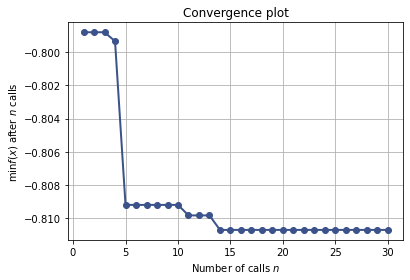

In [166]:
plot_convergence(result) 

## Assign model, fit and predict

In [191]:
## assign model
model = RandomForestClassifier(n_estimators=100, max_depth=9, criterion="entropy")

## cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', 
                           cv=cv, n_jobs=-1, error_score='raise')
print(f"ROC AUC [mean (sd)]: {mean(n_scores).round(4)} ({std(n_scores).round(4)})")

ROC AUC [mean (sd)]: 0.8278 (0.0284)


In [192]:
## fit model
model.fit(X_train, y_train)

## make prediction
y_pred = model.predict(X_test)

## evaluate quality of prediction
metrics.roc_auc_score(y_test, y_pred)

0.7315346345197093